In [1]:
import glob
import os
import warnings
warnings.filterwarnings("ignore")

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import xarray as xr

from esem import gp_model
from scipy import stats
import gpflow

from SALib.sample import fast_sampler
from SALib.analyze import fast

2022-12-07 09:06:23.255834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 09:06:23.372796: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-07 09:06:24.019648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

In [3]:
# Setup your PBSCluster
import dask
from dask.distributed import Client
from dask_jobqueue import PBSCluster

ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [4]:
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.12:38161,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/linnia/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
def get_files(htape,yr0=1850,yr1=2014):
    d='/glade/campaign/asp/djk2120/PPEn11/transient/hist/'

    #find all files
    fs   = np.array(sorted(glob.glob(d+'*'+htape+'*')))
    yrs  = np.array([int(f.split(htape)[1][1:5]) for f in fs])
    keys = np.array([f.split('.clm2')[0][-7:] for f in fs])

    #bump back yr0, if needed
    uyrs=np.unique(yrs)
    dy=uyrs[1]-yrs[0]
    yr0=dy*int(yr0/dy)
    
    #find index to subset files
    ix   = (yrs>=yr0)&(yrs<=yr1)
    yrs  = yrs[ix]
    keys = keys[ix]

    #subset and reshape files
    ny=np.sum(keys=='LHC0000')
    nens = int(len(keys)/ny)
    files = fs[ix].reshape([nens,ny])

    #convert to list of lists
    files = [list(f) for f in files]
    
    return files,np.unique(keys)

In [6]:
def add_params(ds,df,keys):
    mems=df['member'].values
    ix1=0*mems==1
    for key in keys:
        ix1=(ix1)|(mems==key)

    nens=len(ds.ens)    
    ix2=0*np.arange(nens)==1
    for mem in mems:
        ix2=(ix2)|(ds.key==mem)


    params=[]    
    for p in df.keys():
        if p!='member':
            x=xr.DataArray(np.nan+np.zeros(nens),dims='ens')
            x[ix2]=df[p][ix1]
            ds[p]=x
            params.append(p)
    ds['params']=xr.DataArray(params,dims='param')

In [7]:
def get_ds(dvs,htape,yr0=1850,yr1=2014,dropdef=False):
    
    def preprocess(ds):
        return ds[dvs]
    
    #read in the data
    files,keys = get_files(htape,yr0,yr1)
    if dropdef:
        files = files[1:]
        keys  = keys[1:]
    
    ds = xr.open_mfdataset(files,combine='nested',concat_dim=['ens','time'],
                       parallel=True,preprocess=preprocess)
    
    #fix the time dimension, if needed
    yr0=str(ds['time.year'].values[0])
    if (htape=='h0')|(htape=='h1'):
        ds['time']=xr.cftime_range(yr0,periods=len(ds.time),freq='MS',calendar='noleap')
    
    #add some param info, etc.
    df=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt')
    ds['key']=xr.DataArray(keys,dims=['ens'])
    add_params(ds,df,keys)
    
    #add landarea info
    la_file = '/glade/u/home/djk2120/clm5ppe/pyth/sparsegrid_landarea.nc'
    la = xr.open_dataset(la_file).landarea  #km2
    ds['la'] = la
    
    #add some extra variables, e.g. lat/lon
    tmp = xr.open_dataset(files[0][0])
    for v in tmp.data_vars:
        if 'time' not in tmp[v].dims:
            ds[v]=tmp[v]   
    
    return ds

In [8]:
def gmean(da,la,cf=1):
    #global mean
    xg=cf/la.sum()*(la*da).sum(dim='gridcell').compute()
    return xg
whit = xr.open_dataset('./whit/whitkey.nc')
def bmean(da,la):
    g=whit.biome
    xb=1/la.groupby(g).sum()*(la*da).groupby(g).sum(dim='gridcell').compute()
    xb['biome_name']=xr.DataArray(whit.biome_name.values,dims='biome')
    return xb
def amean(da,cf=1):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf/365*(m*da).groupby('time.year').sum().compute()
    return xa

In [9]:
def normalize(var):
    return (var-min(var))/(max(var)-min(var))

def unnormalize(norm_var,raw_var):
    return norm_var*np.array(max(raw_var)-min(raw_var)) + np.array(min(raw_var))

### Read in dataset

In [10]:
dvs = ['TLAI','GPP','EFLX_LH_TOT','TWS','ER']
htape='h0'
ds=get_ds(dvs,htape,yr0=2005,yr1=2014)

In [11]:
# get parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)

### Global mean annual mean GPP

In [12]:
# select target variable and divide LHC dataset into training and testing subsets
var_raw=gmean(amean(ds.GPP).mean(dim='year'),ds.la)*24*60*60 #Global avg GPP (kgC/m2/day)
var = normalize(var_raw)
n_test = 50 # number of ensemble members to test emulator
Y = var[1:].values # target variable excluding default model [0]
default = var[0].values # default model value

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

In [13]:
# define kernal
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

kernel = kernel_linear + kernel_matern32

# define emulator model and train
emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
emulator.train()

2022-12-07 09:07:11.672349: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-07 09:07:11.672395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc11): /proc/driver/nvidia/version does not exist
2022-12-07 09:07:11.685302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


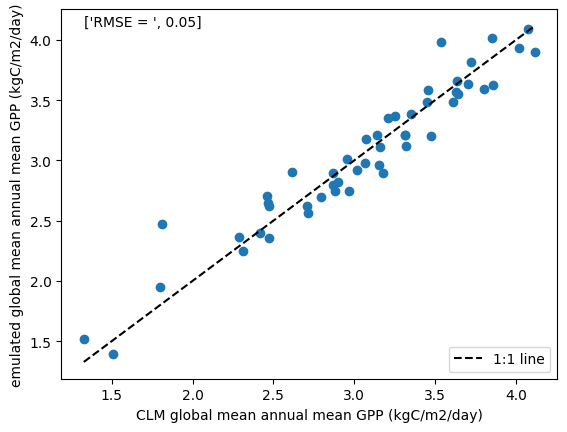

In [14]:
# Predict test points with emulator
y_pred, y_pred_var = emulator.predict(X_test.values)

# plot predicted values
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_test, y_pred, squared=False)


y_test_raw = unnormalize(y_test,var_raw)

plt.scatter(y_test_raw,unnormalize(y_pred,var_raw))
plt.plot([min(y_test_raw),max(y_test_raw)],[min(y_test_raw),max(y_test_raw)],c='k',linestyle='--',label='1:1 line')
plt.text(min(y_test_raw),max(y_test_raw),['RMSE = ',np.round(rms,3)])
plt.xlabel('CLM global mean annual mean GPP (kgC/m2/day)')
plt.ylabel('emulated global mean annual mean GPP (kgC/m2/day)')
plt.legend(loc = 'lower right')

In [15]:
# One-at-a-time sensitivity 
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = ppe_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

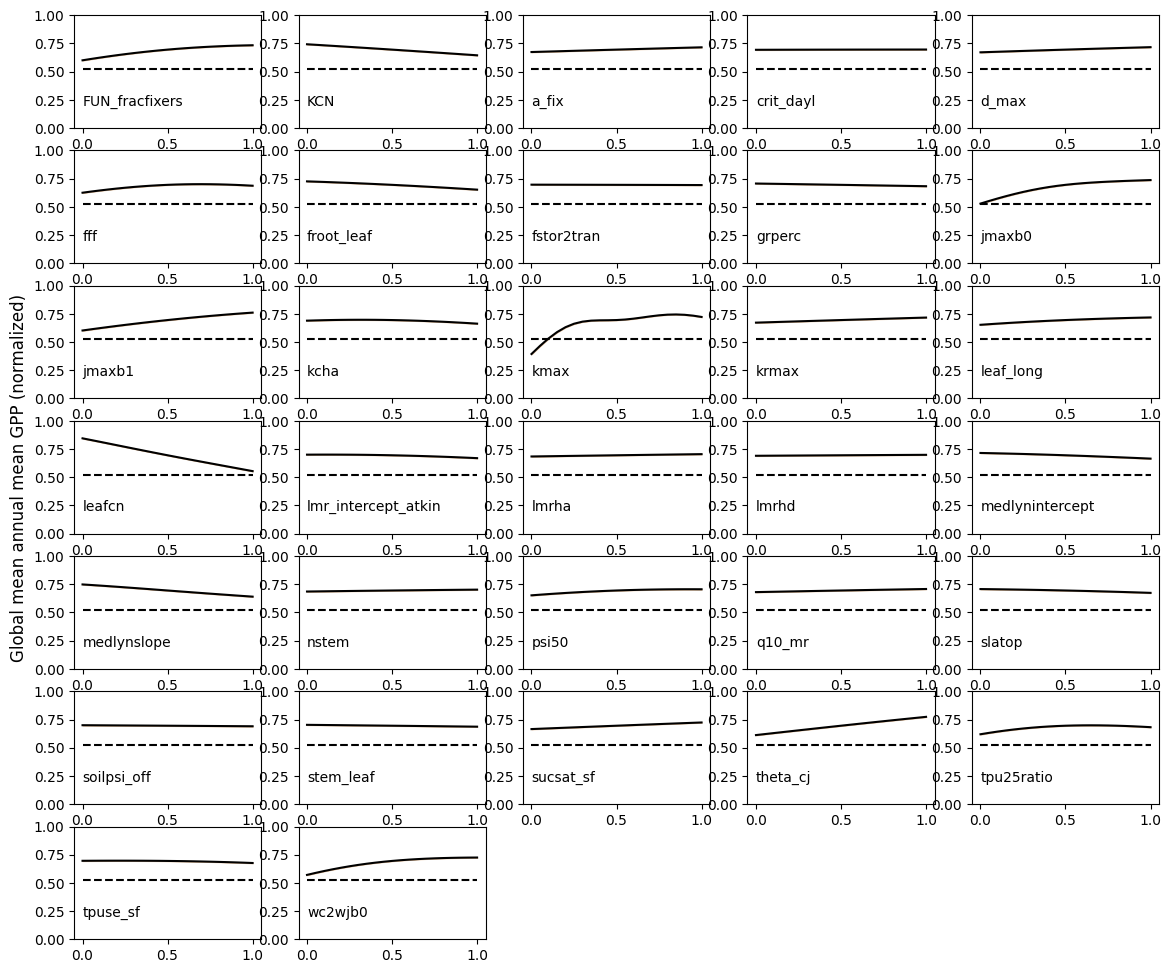

In [16]:
plt.figure(figsize=[14,12])
sample = unif
for i, p in enumerate(ppe_params.columns):
    
    sample[p] = s
    oaat, sd = emulator.predict(sample)
    sample[p] = np.tile(0.5,n) # set column back to median
    
    ax=plt.subplot(7,5,i+1)
    ax.fill_between(s, oaat-3.0*sd, oaat+3.0*sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='k')
    plt.text(0,0.2,p)
    plt.plot([0,1],[default, default],'--',c='k')
    ax.set_ylim([0,1])
    if i == 15:
        plt.ylabel('Global mean annual mean GPP (normalized)',fontsize=12)
    
plt.savefig('../figs/param_sens/OAAT_sensitivity_GM-AM_GPP.png',dpi=200)

In [17]:
# fourier amplitude sensitivity test
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
Y, _ = emulator.predict(sample)
FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
gpp_sens = pd.DataFrame.from_dict(FAST)
gpp_sens.index = gpp_sens.names
df_sens = gpp_sens.sort_values(by=['S1'],ascending=False)

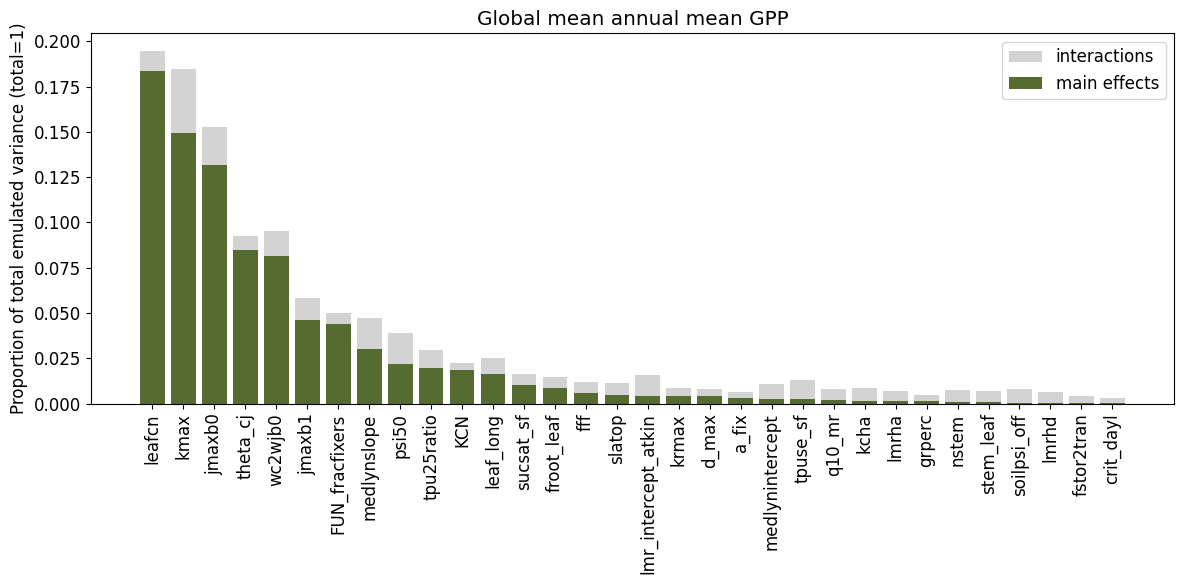

In [18]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_sens.names,df_sens['ST'],color='lightgrey',label='interactions')
ax.bar(df_sens.names,df_sens['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Proportion of total emulated variance (total=1)')
plt.title('Global mean annual mean GPP')
plt.tight_layout()
plt.savefig('../figs/param_sens/FAST_sensitivity_GM-AM_GPP.png',dpi=200)

### Global mean annual mean Respiration

In [19]:
# select target variable and divide LHC dataset into training and testing subsets
var_raw=gmean(amean(ds.ER).mean(dim='year'),ds.la)*24*60*60 #Global avg RE (kgC/m2/day)
var = normalize(var_raw)
n_test = 50 # number of ensemble members to test emulator
Y = var[1:].values # target variable excluding default model [0]
default = var[0].values # default model value

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

In [20]:
# define kernal
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))
#kernel_poly = gpflow.kernels.Polynomial(active_dims=range(num_params),variance=3,offset=0)

kernel = kernel_linear + kernel_matern32

# define emulator model and train
emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
emulator.train()

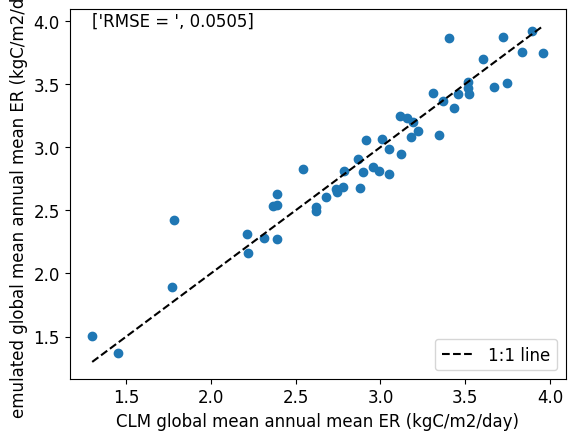

In [21]:
# Predict test points with emulator
y_pred, y_pred_var = emulator.predict(X_test.values)

# plot predicted values
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_test, y_pred, squared=False)

y_test_raw = unnormalize(y_test,var_raw)

plt.scatter(y_test_raw,unnormalize(y_pred,var_raw))
plt.plot([min(y_test_raw),max(y_test_raw)],[min(y_test_raw),max(y_test_raw)],c='k',linestyle='--',label='1:1 line')
plt.text(min(y_test_raw),max(y_test_raw),['RMSE = ',np.round(rms,4)])
plt.xlabel('CLM global mean annual mean ER (kgC/m2/day)')
plt.ylabel('emulated global mean annual mean ER (kgC/m2/day)')
plt.legend(loc='lower right')

In [22]:
# One-at-a-time sensitivity 
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = ppe_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

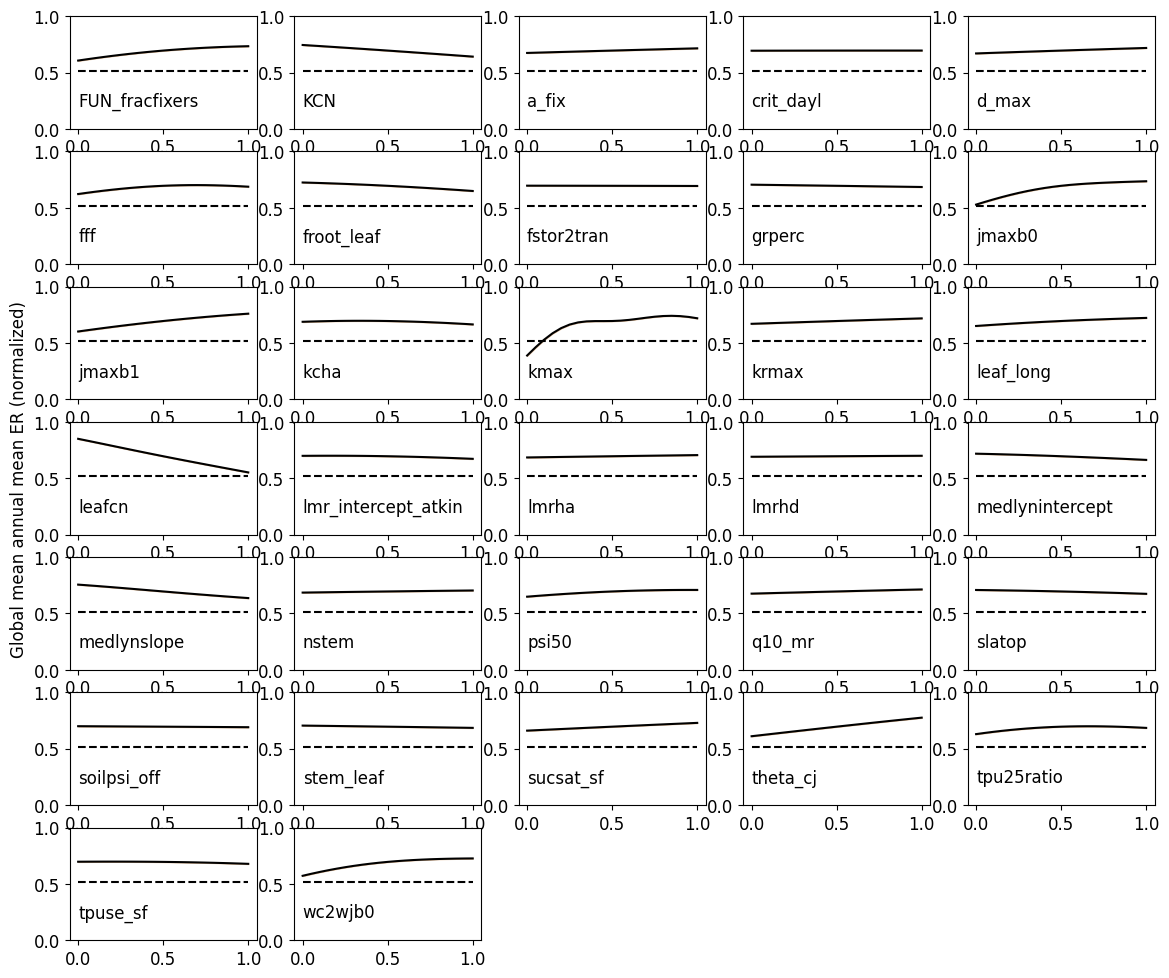

In [23]:
plt.figure(figsize=[14,12])
sample = unif
for i, p in enumerate(ppe_params.columns):
    
    sample[p] = s
    oaat, sd = emulator.predict(sample)
    sample[p] = np.tile(0.5,n) # set column back to median
    
    ax=plt.subplot(7,5,i+1)
    ax.fill_between(s, oaat-3.0*sd, oaat+3.0*sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='k')
    plt.text(0,0.2,p)
    plt.plot([0,1],[default, default],'--',c='k')
    ax.set_ylim([0,1])
    if i == 15:
        plt.ylabel('Global mean annual mean ER (normalized)',fontsize=12)
    
plt.savefig('../figs/param_sens/OAAT_sensitivity_GM-AM_ER.png',dpi=200)

In [24]:
# fourier amplitude sensitivity test
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
Y, _ = emulator.predict(sample)
FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
er_sens = pd.DataFrame.from_dict(FAST)
er_sens.index = er_sens.names
df_sens = er_sens.sort_values(by=['S1'],ascending=False)

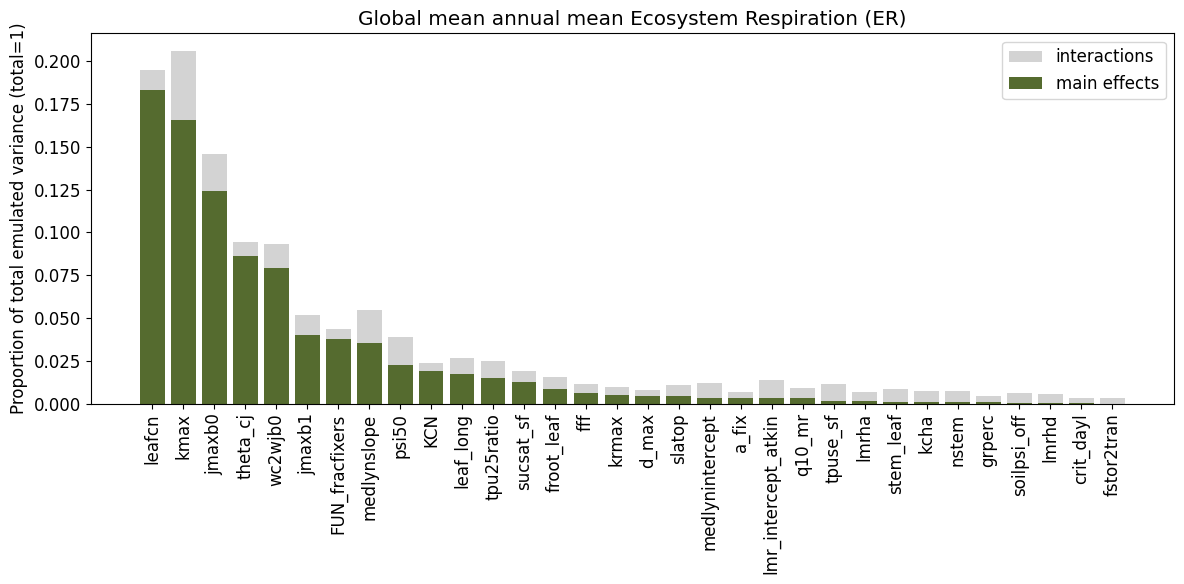

In [25]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_sens.names,df_sens['ST'],color='lightgrey',label='interactions')
ax.bar(df_sens.names,df_sens['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Proportion of total emulated variance (total=1)')
plt.title('Global mean annual mean Ecosystem Respiration (ER)')
plt.tight_layout()
plt.savefig('../figs/param_sens/FAST_sensitivity_GM-AM_ER.png',dpi=200)

### Global mean annual mean Evapotranspiration (W/m2)

In [26]:
# select target variable and divide LHC dataset into training and testing subsets
var_raw = gmean(amean(ds.EFLX_LH_TOT).mean(dim='year'),ds.la)
var = normalize(var_raw)
n_test = 50 # number of ensemble members to test emulator
Y = var[1:].values # target variable excluding default model [0]
default = var[0].values # default model value

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

In [27]:
# define kernal
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))
#kernel_poly = gpflow.kernels.Polynomial(active_dims=range(num_params),variance=3,offset=0)

kernel = kernel_linear + kernel_matern32

# define emulator model and train
emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
emulator.train()

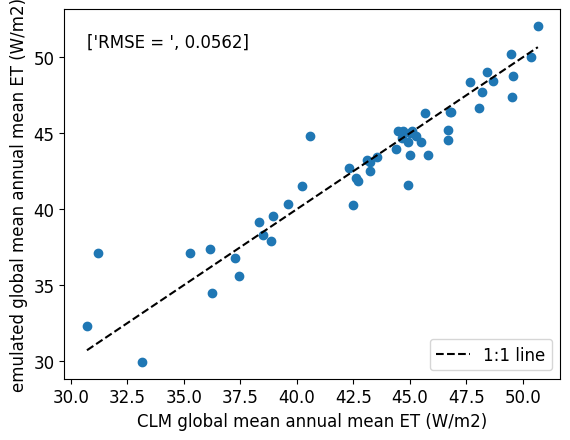

In [28]:
# Predict test points with emulator
y_pred, y_pred_var = emulator.predict(X_test.values)

# plot predicted values
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_test, y_pred, squared=False)

y_test_raw = unnormalize(y_test,var_raw)

plt.scatter(y_test_raw,unnormalize(y_pred,var_raw))
plt.plot([min(y_test_raw),max(y_test_raw)],[min(y_test_raw),max(y_test_raw)],c='k',linestyle='--',label='1:1 line')
plt.text(min(y_test_raw),max(y_test_raw),['RMSE = ',np.round(rms,4)])
plt.xlabel('CLM global mean annual mean ET (W/m2)')
plt.ylabel('emulated global mean annual mean ET (W/m2)')
plt.legend(loc='lower right')

In [29]:
# One-at-a-time sensitivity
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = ppe_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

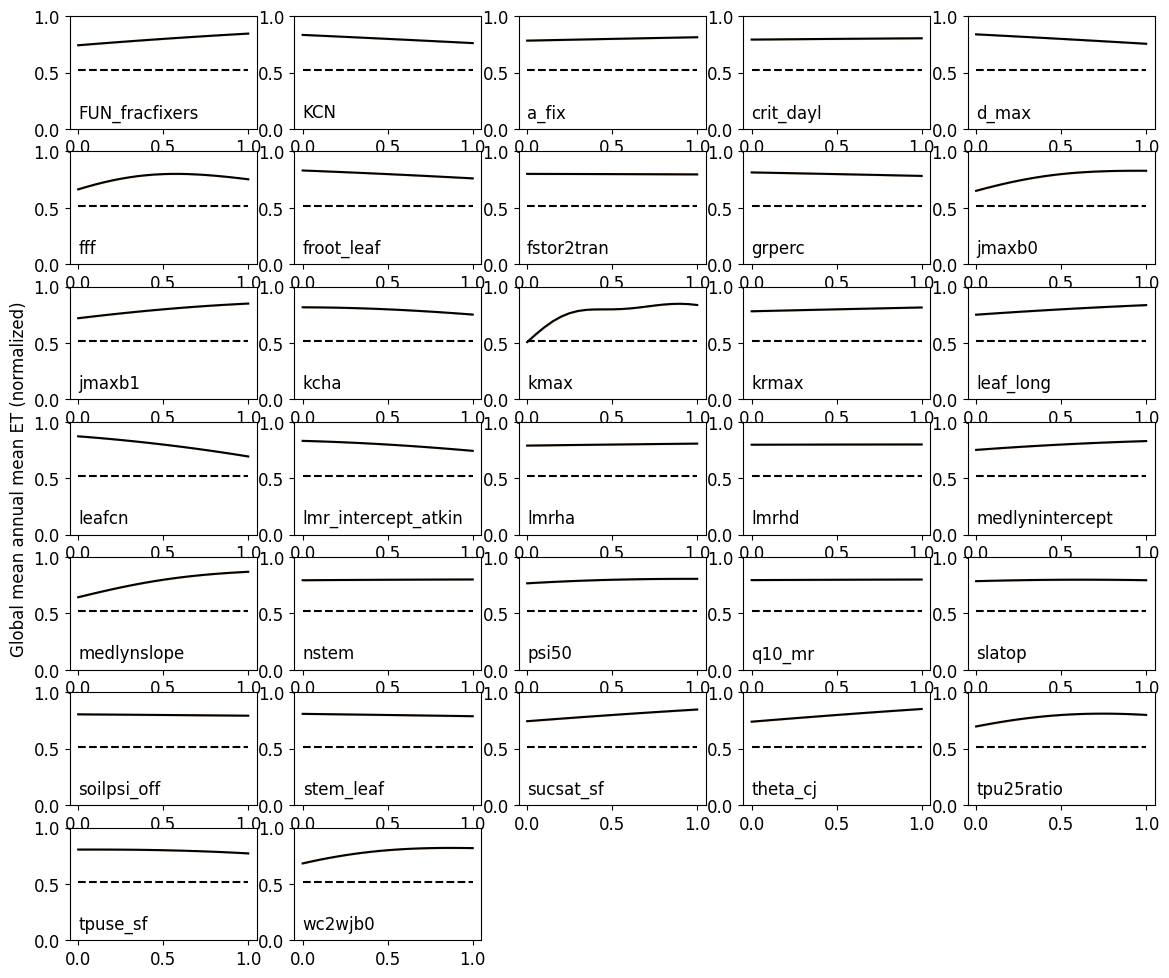

In [30]:
plt.figure(figsize=[14,12])
sample = unif
for i, p in enumerate(ppe_params.columns):
    
    sample[p] = s
    oaat, sd = emulator.predict(sample)
    sample[p] = np.tile(0.5,n) # set column back to median
    
    ax=plt.subplot(7,5,i+1)
    ax.fill_between(s, oaat-3.0*sd, oaat+3.0*sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='k')
    plt.text(0,0.1,p)
    plt.plot([0,1],[default, default],'--',c='k')
    ax.set_ylim([0,1])
    if i == 15:
        plt.ylabel('Global mean annual mean ET (normalized)',fontsize=12)
    
plt.savefig('../figs/param_sens/OAAT_sensitivity_GM-AM_ET.png',dpi=200)

In [31]:
# fourier amplitude sensitivity test
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
Y, _ = emulator.predict(sample)
FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
et_sens = pd.DataFrame.from_dict(FAST)
et_sens.index = et_sens.names
df_sens = et_sens.sort_values(by=['S1'],ascending=False)

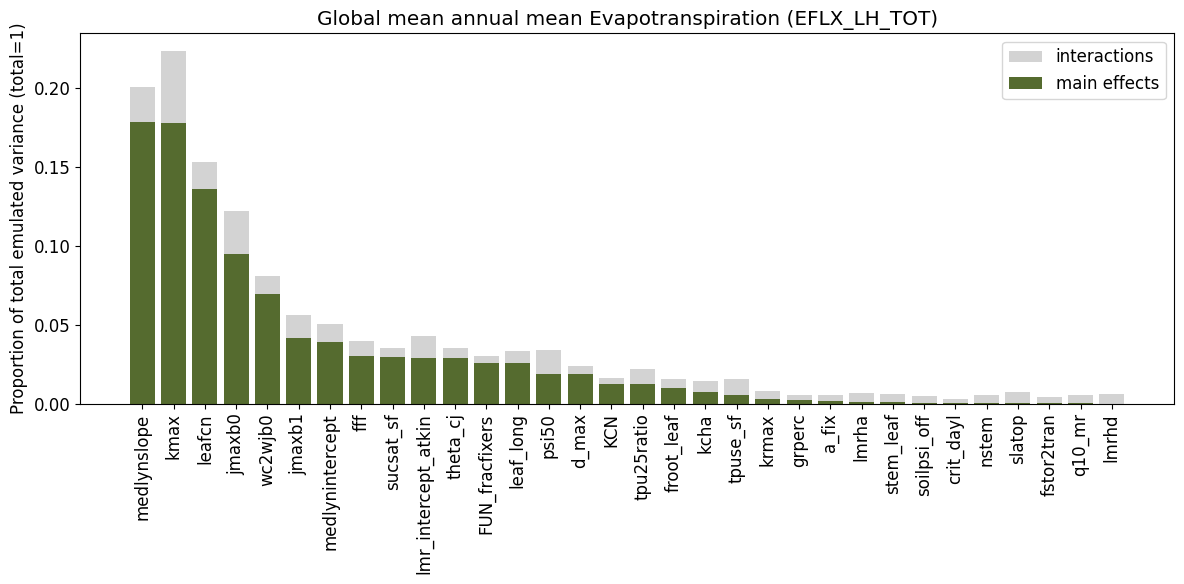

In [32]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_sens.names,df_sens['ST'],color='lightgrey',label='interactions')
ax.bar(df_sens.names,df_sens['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Proportion of total emulated variance (total=1)')
plt.title('Global mean annual mean Evapotranspiration (EFLX_LH_TOT)')
plt.tight_layout()
plt.savefig('../figs/param_sens/FAST_sensitivity_GM-AM_ET.png',dpi=200)

### Global mean annual mean total soil water

In [33]:
# select target variable and divide LHC dataset into training and testing subsets
var_raw = gmean(amean(ds.TWS).mean(dim='year'),ds.la)
var = normalize(var_raw)
n_test = 50 # number of ensemble members to test emulator
Y = var[1:].values # target variable excluding default model [0]
default = var[0].values # default model value

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

In [34]:
# define kernal
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))
#kernel_poly = gpflow.kernels.Polynomial(active_dims=range(num_params),variance=3,offset=0)

kernel = kernel_linear + kernel_matern32

# define emulator model and train
emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
emulator.train()

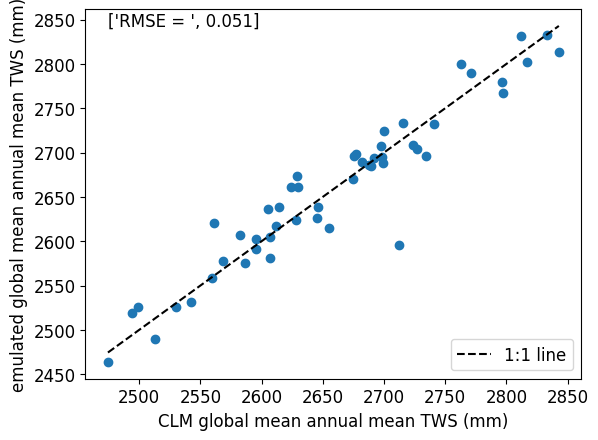

In [35]:
# Predict test points with emulator
y_pred, y_pred_var = emulator.predict(X_test.values)

# plot predicted values
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_test, y_pred, squared=False)

y_test_raw = unnormalize(y_test,var_raw)

plt.scatter(y_test_raw,unnormalize(y_pred,var_raw))
plt.plot([min(y_test_raw),max(y_test_raw)],[min(y_test_raw),max(y_test_raw)],c='k',linestyle='--',label='1:1 line')
plt.text(min(y_test_raw),max(y_test_raw),['RMSE = ',np.round(rms,4)])
plt.xlabel('CLM global mean annual mean TWS (mm)')
plt.ylabel('emulated global mean annual mean TWS (mm)')
plt.legend(loc='lower right')

In [36]:
# One-at-a-time sensitivity
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = ppe_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

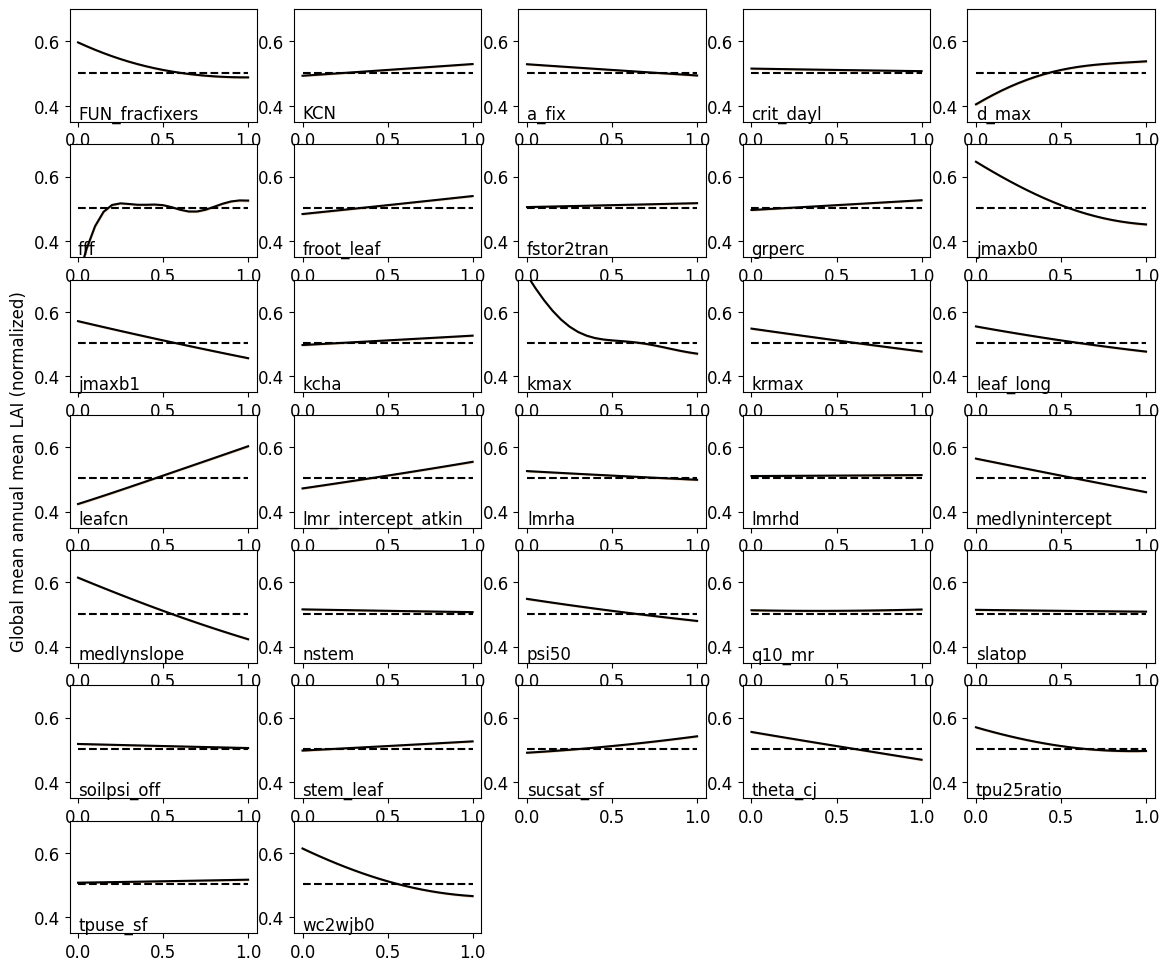

In [37]:
plt.figure(figsize=[14,12])
sample = unif
for i, p in enumerate(ppe_params.columns):
    
    sample[p] = s
    oaat, sd = emulator.predict(sample)
    sample[p] = np.tile(0.5,n) # set column back to median
    
    ax=plt.subplot(7,5,i+1)
    ax.fill_between(s, oaat-3.0*sd, oaat+3.0*sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='k')
    plt.text(0,0.36,p)
    plt.plot([0,1],[default, default],'--',c='k')
    ax.set_ylim([0.35,0.7])
    if i == 15:
        plt.ylabel('Global mean annual mean LAI (normalized)',fontsize=12)
    
plt.savefig('../figs/param_sens/OAAT_sensitivity_GM-AM_TWS.png',dpi=200)

In [38]:
# fourier amplitude sensitivity test
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
Y, _ = emulator.predict(sample)
FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
tws_sens = pd.DataFrame.from_dict(FAST)
tws_sens.index = tws_sens.names
df_sens = tws_sens.sort_values(by=['S1'],ascending=False)

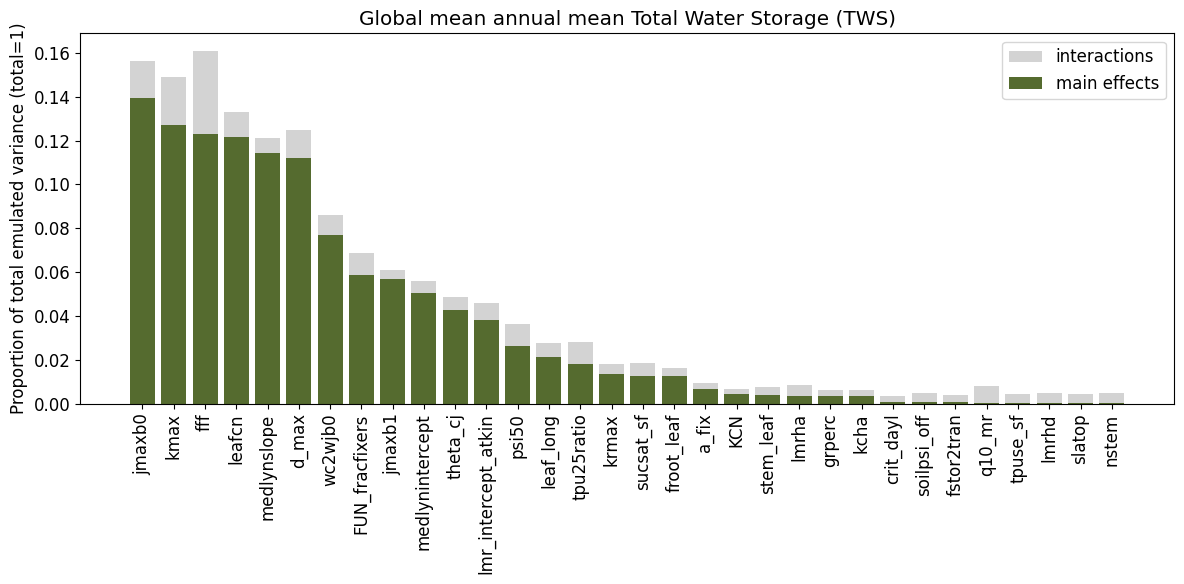

In [39]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_sens.names,df_sens['ST'],color='lightgrey',label='interactions')
ax.bar(df_sens.names,df_sens['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Proportion of total emulated variance (total=1)')
plt.title('Global mean annual mean Total Water Storage (TWS)')
plt.tight_layout()
plt.savefig('../figs/param_sens/FAST_sensitivity_GM-AM_TWS.png',dpi=200)

### Global mean annual mean LAI

In [40]:
# select target variable and divide LHC dataset into training and testing subsets
var_raw = gmean(amean(ds.TLAI).mean(dim='year'),ds.la)
var = normalize(var_raw)
n_test = 50 # number of ensemble members to test emulator
Y = var[1:].values # target variable excluding default model [0]
default = var[0].values # default model value

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

In [41]:
# define kernal
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))
#kernel_poly = gpflow.kernels.Polynomial(active_dims=range(num_params),variance=3,offset=0)

kernel = kernel_linear + kernel_matern32

# define emulator model and train
emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
emulator.train()

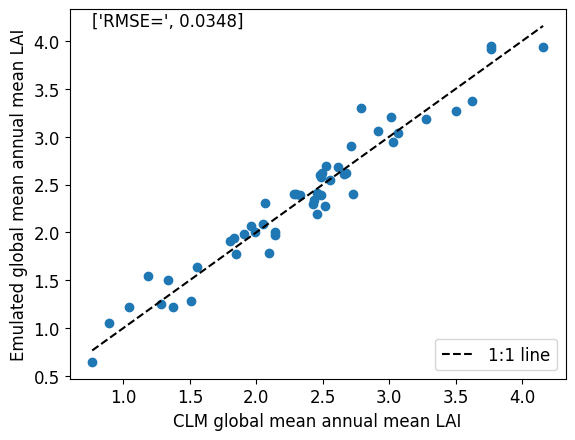

In [42]:
# Predict test points with emulator
y_pred, y_pred_var = emulator.predict(X_test.values)

# plot predicted values
rms = mean_squared_error(y_test, y_pred, squared=False)

y_test_raw = unnormalize(y_test,var_raw)

plt.scatter(y_test_raw,unnormalize(y_pred,var_raw))
plt.plot([min(y_test_raw),max(y_test_raw)],[min(y_test_raw),max(y_test_raw)],c='k',linestyle='--',label='1:1 line')
plt.text(min(y_test_raw),max(y_test_raw),['RMSE=',np.round(rms,4)])
plt.xlabel('CLM global mean annual mean LAI')
plt.ylabel('Emulated global mean annual mean LAI')
plt.legend(loc='lower right')

In [43]:
# One-at-a-time sensitivity
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = ppe_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

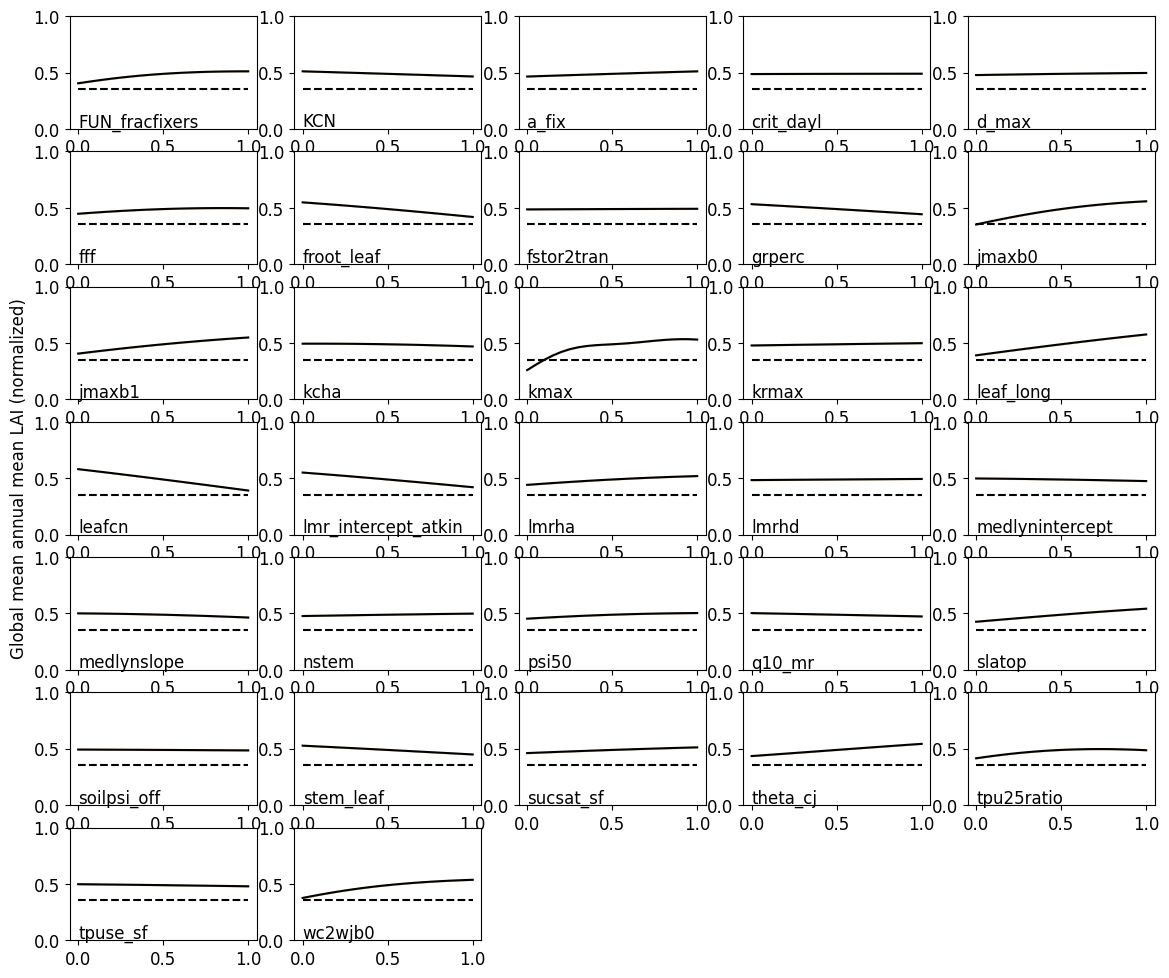

In [44]:
plt.figure(figsize=[14,12])
sample = unif
for i, p in enumerate(ppe_params.columns):
    
    sample[p] = s
    oaat, sd = emulator.predict(sample)
    sample[p] = np.tile(0.5,n) # set column back to median
    
    ax=plt.subplot(7,5,i+1)
    ax.fill_between(s, oaat-3.0*sd, oaat+3.0*sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='k')
    plt.text(0,0.02,p)
    plt.plot([0,1],[default, default],'--',c='k')
    ax.set_ylim([0,1])
    if i == 15:
        plt.ylabel('Global mean annual mean LAI (normalized)',fontsize=12)
    
#plt.savefig('../figs/param_sens/OAAT_sensitivity_GM-AM_LAI.png',dpi=200)

In [45]:
# fourier amplitude sensitivity test
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
Y, _ = emulator.predict(sample)
FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
lai_sens = pd.DataFrame.from_dict(FAST)
lai_sens.index = lai_sens.names
df_sens = lai_sens.sort_values(by=['S1'],ascending=False)

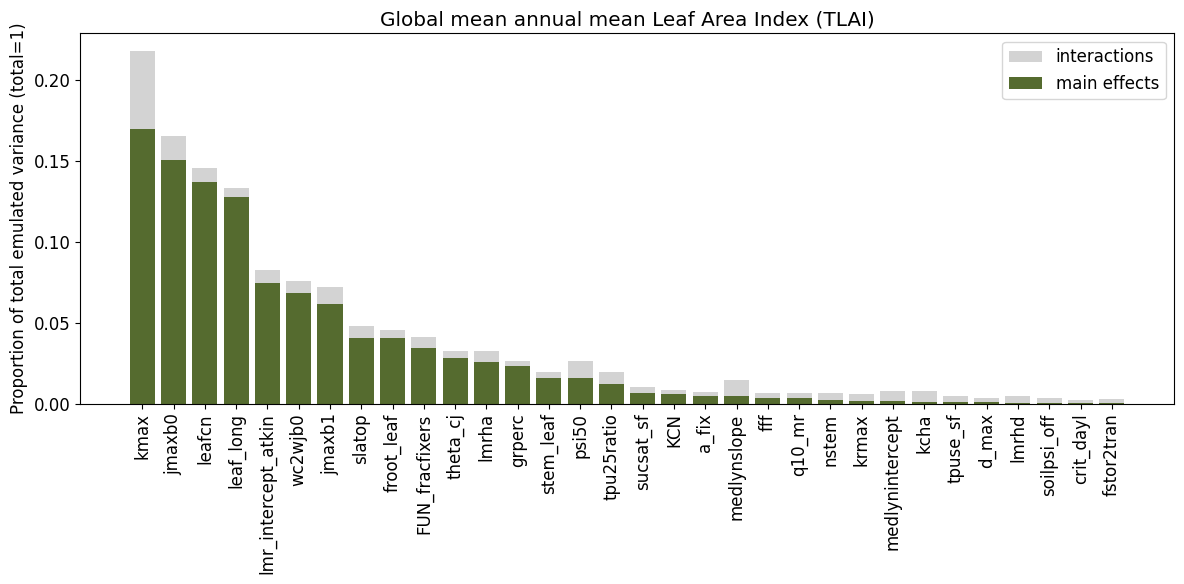

In [46]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.subplot
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_sens.names,df_sens['ST'],color='lightgrey',label='interactions')
ax.bar(df_sens.names,df_sens['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Proportion of total emulated variance (total=1)')
plt.title('Global mean annual mean Leaf Area Index (TLAI)')
plt.tight_layout()
#plt.savefig('../figs/param_sens/FAST_sensitivity_GM-AM_TLAI.png',dpi=200)

### Heatmap

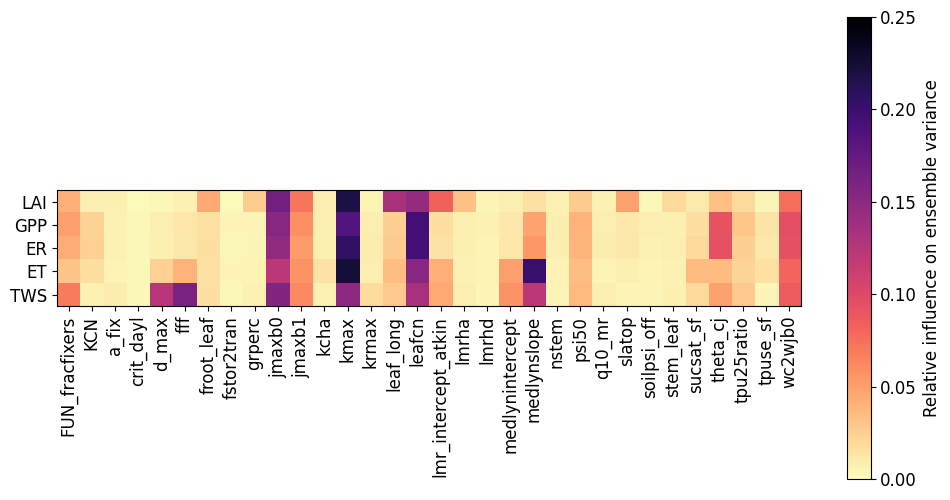

In [47]:
# heatmap of all global mean variables
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')

sensitivity = [lai_sens['ST'],gpp_sens['ST'],er_sens['ST'],et_sens['ST'],tws_sens['ST']]
params = gpp_sens.names 
var_names = ['LAI','GPP','ER','ET','TWS']

ax = plt.subplot(1,1,1)
im = ax.imshow(sensitivity,cmap='magma_r',vmin=0,vmax=0.25)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(params)), labels=params)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_yticks(np.arange(len(var_names)), labels=var_names)

cbar = plt.colorbar(im)
cbar.set_label("Relative influence on ensemble variance")

plt.savefig('../figs/param_sens/FAST_sensitivity_GM-AM_heatmap.png',dpi=200)
